<a href="https://colab.research.google.com/github/Devanshu070/Stock-Price-prediction-using-technical-indicators-and-ML-models/blob/main/Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
import yfinance as yf

In [2]:
# Define the stock ticker symbol
ticker_symbol = '^NSEI'  # Example: Apple Inc.

# Download historical data for the past 3 years
data = yf.download(ticker_symbol, start='2022-01-01', end='2025-01-01')
print("")
# Display the first few rows of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  Volume
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI   ^NSEI
Date                                                                      
2022-01-03  17625.699219  17646.650391  17383.300781  17387.150391  200500
2022-01-04  17805.250000  17827.599609  17593.550781  17681.400391  247400
2022-01-05  17925.250000  17944.699219  17748.849609  17820.099609  251500
2022-01-06  17745.900391  17797.949219  17655.550781  17768.500000  236500
2022-01-07  17812.699219  17905.000000  17704.550781  17797.599609  239300


In [3]:
print("Column names:", data.columns.get_level_values(0))

Column names: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


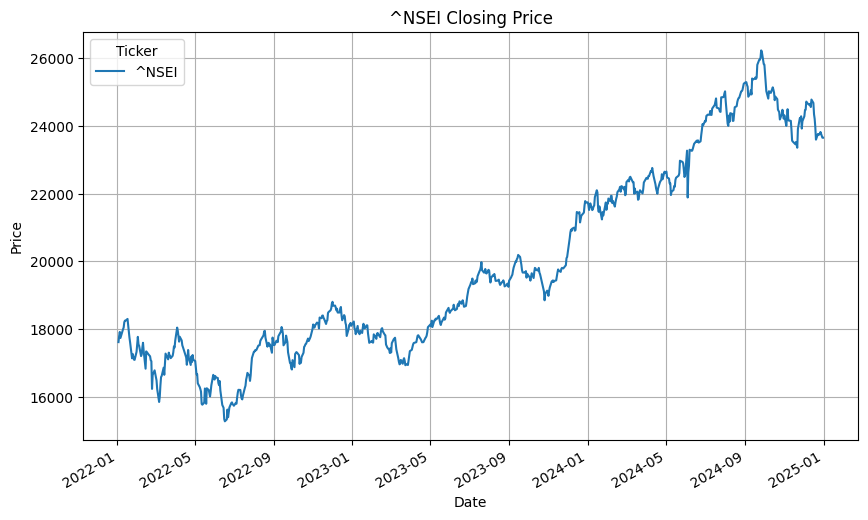

In [4]:
import matplotlib.pyplot as plt

# Plot the closing prices
data['Close'].plot(figsize=(10, 6), title=f'{ticker_symbol} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

In [5]:
def check_missing_values(df):
    """
    Function to check and print the count of missing values per column.
    Also provides a message if there are no missing values.
    """
    missing_values = df.isnull().sum()  # Get missing values per column
    total_missing = missing_values.sum()  # Total missing values across all columns

    # Print the missing values per column
    print("Missing values per column:")
    print(missing_values)

    # Provide a message based on the result
    if total_missing == 0:
        print("\nGreat! There are no missing values in the dataset.")
    else:
        print(f"\nThere are {total_missing} missing values in the dataset.")

# Example usage
check_missing_values(data)

Missing values per column:
Price   Ticker
Close   ^NSEI     0
High    ^NSEI     0
Low     ^NSEI     0
Open    ^NSEI     0
Volume  ^NSEI     0
dtype: int64

Great! There are no missing values in the dataset.


In [6]:
def detect_outliers(df, column, ticker):
    col_data = df[column][ticker]

    Q1 = col_data.quantile(0.25)  # 25th percentile
    Q3 = col_data.quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check for outliers
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

    # Detect rows where values are outside the bounds
    outliers = df[(col_data < lower_bound) | (col_data > upper_bound)]
    if outliers.empty:
        print("No outliers detected!")
    return outliers

# Example: Detect outliers in the 'Close' column for ticker '^NSEI'
outliers = detect_outliers(data, 'Close', '^NSEI')
print("\nOutliers in 'Close':")
print(outliers)

Lower bound: 10652.55029296875, Upper bound: 29200.74951171875
No outliers detected!

Outliers in 'Close':
Empty DataFrame
Columns: [(Close, ^NSEI), (High, ^NSEI), (Low, ^NSEI), (Open, ^NSEI), (Volume, ^NSEI)]
Index: []


In [7]:
from scipy.stats import zscore
import pandas as pd

def detect_outliers_with_zscore(df, threshold=3):
    """
    Detect outliers in a DataFrame using Z-score.

    Parameters:
        df (DataFrame): The dataset to analyze.
        threshold (float): The Z-score threshold to identify outliers (default is 3).

    Returns:
        DataFrame: Rows with outliers based on the Z-score method.
    """
    # Calculate Z-scores for all numeric columns
    z_scores = df.apply(zscore)

    # Identify rows where any Z-score exceeds the threshold
    outliers = df[(z_scores.abs() > threshold).any(axis=1)]

    # Print results
    print(f"Outliers detected using Z-score (Threshold = {threshold}):")
    if outliers.empty:
        print("No outliers detected!")
    else:
        print(outliers)
        print(f"\nNumber of outliers detected: {len(outliers)}")

    return outliers

# Example usage
outliers = detect_outliers_with_zscore(data)

Outliers detected using Z-score (Threshold = 3):
Price              Close          High           Low          Open   Volume
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI    ^NSEI
Date                                                                       
2022-03-07  15863.150391  15944.599609  15711.450195  15867.950195   585400
2022-05-31  16584.550781  16690.750000  16521.900391  16578.449219   651600
2022-08-16  17825.250000  17839.099609  17764.050781  17797.199219        0
2023-03-22  17151.900391  17207.250000  17107.849609  17177.449219        0
2023-05-31  18534.400391  18603.900391  18483.849609  18594.199219   696500
2023-08-16  19465.000000  19482.750000  19317.199219  19369.000000        0
2024-02-19  22122.250000  22186.650391  22021.050781  22103.449219        0
2024-03-15  22023.349609  22120.900391  21931.699219  22064.849609   661500
2024-04-01  22462.000000  22529.949219  22427.750000  22455.000000        0
2024-05-31  22530.699219  22653.750000 

<ipython-input-8-aa4d4bf88057>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(value)


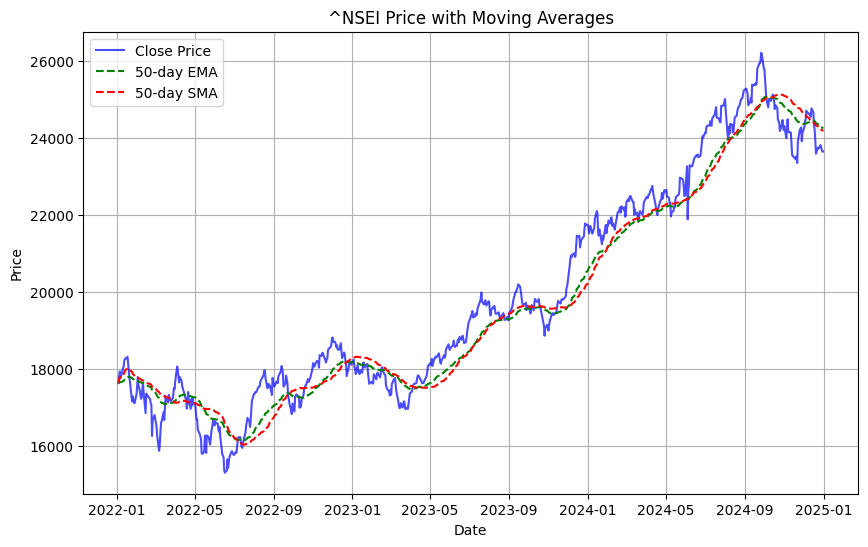

In [8]:
#Feature Engineering:
# data = data.drop(columns=['EMA_50'])
# 1. Moving Averages: SMA and EMA

# dynamic sma approach is used os that none of the values are nan, for first 50 respective window size is used and from there constant window size of 50 is used
def dynamic_sma(data, max_window=50):
    sma_values = []

    # Iterate through each row in the DataFrame
    for i in range(len(data)):
        window_size = min(i + 1, max_window)  # Use dynamic window size up to max_window (50)

        # Calculate the moving average using the current window size
        value=data['Close'].iloc[i-window_size+1:i+1].mean()
        value = float(value)
        sma_values.append(value)  # Calculate mean over the first (i+1) rows


    return sma_values

# Apply the dynamic SMA calculation
data['SMA_50'] = dynamic_sma(data)
# data['SMA_50'] = data['Close'].rolling(window=50).mean()  # 50-day Simple Moving Average

data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()  # 50-day Exponential Moving Average

#Data Visualization

# 1. Plot Stock’s Price Data with SMA, EMA
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(data['EMA_50'], label='50-day EMA', color='green', linestyle='--')
plt.plot(data['SMA_50'], label='50-day SMA', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')


plt.grid(True)
plt.legend()
plt.title(f'{ticker_symbol} Price with Moving Averages')
plt.show()

In [9]:
data.head()

Price,Close,High,Low,Open,Volume,SMA_50,EMA_50
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,
Date,,,,,,,
2022-01-03,17625.699219,17646.650391,17383.300781,17387.150391,200500,17625.699219,17625.699219
2022-01-04,17805.250000,17827.599609,17593.550781,17681.400391,247400,17715.474609,17632.740426
2022-01-05,17925.250000,17944.699219,17748.849609,17820.099609,251500,17785.399740,17644.211390
2022-01-06,17745.900391,17797.949219,17655.550781,17768.500000,236500,17775.524902,17648.199194
2022-01-07,17812.699219,17905.000000,17704.550781,17797.599609,239300,17782.959766,17654.650175


In [10]:
data['SMA_50']

,SMA_50
Date,
2022-01-03,17625.699219
2022-01-04,17715.474609
2022-01-05,17785.399740
2022-01-06,17775.524902
2022-01-07,17782.959766
...,...
2024-12-24,24276.136055
2024-12-26,24248.581055
2024-12-27,24223.702070


In [11]:
import pandas as pd

# Calculate the RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()  # Calculate the difference between consecutive days

    # Separate the gains and losses
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()

    # Calculate the relative strength (RS)
    rs = gain / loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

data['RSI'] = calculate_rsi(data)

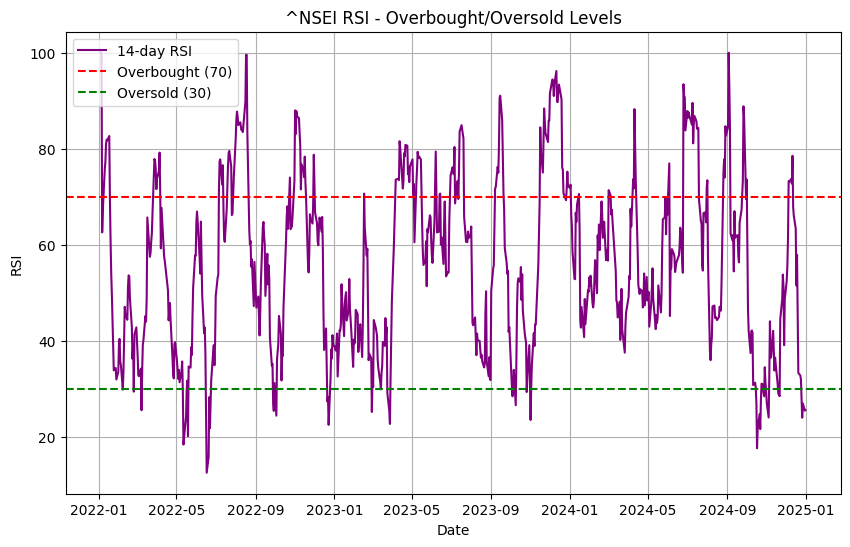

In [12]:
# Plot the RSI
plt.figure(figsize=(10, 6))
plt.plot(data['RSI'], label='14-day RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title(f'{ticker_symbol} RSI - Overbought/Oversold Levels')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.legend()
plt.show()

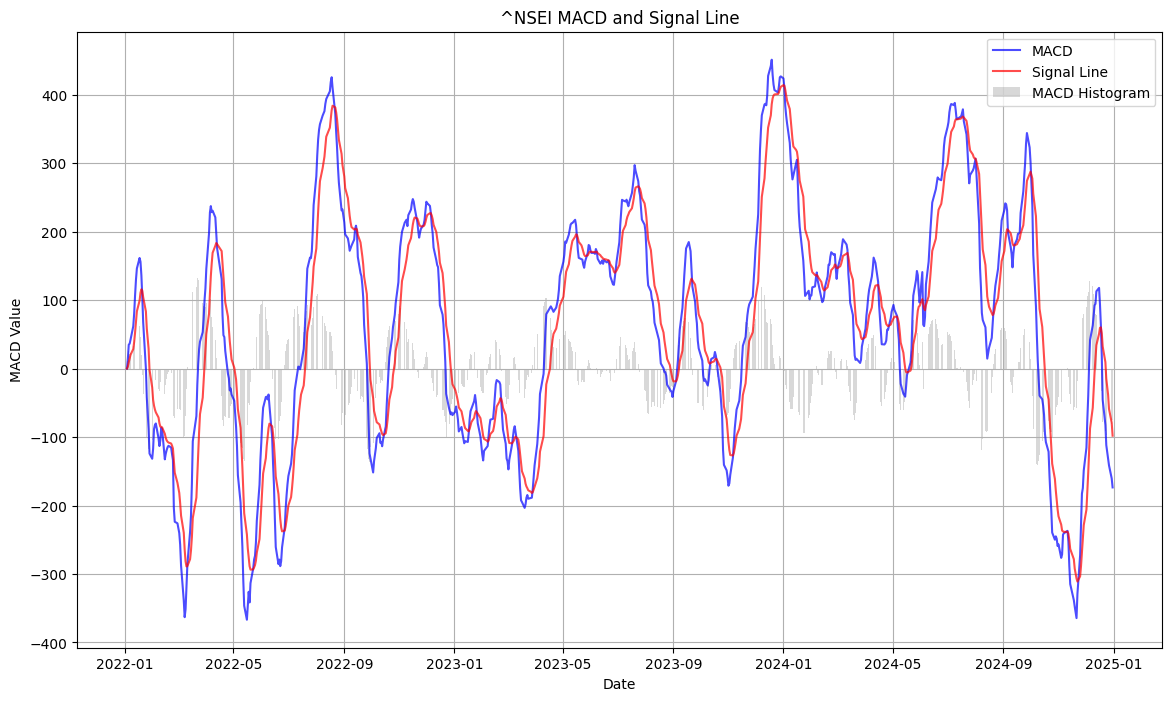

In [13]:
# 3. Moving Average Convergence Divergence (MACD)
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()  # 12-period EMA
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()  # 26-period EMA
data['MACD'] = data['EMA_12'] - data['EMA_26']  # MACD Line
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()  # Signal Line (9-period EMA of MACD)

# 3. Plot MACD and Signal Line
plt.figure(figsize=(14, 8))
plt.plot(data['MACD'], label='MACD', color='blue', alpha=0.7)
plt.plot(data['Signal_Line'], label='Signal Line', color='red', alpha=0.7)
plt.bar(data.index, data['MACD'] - data['Signal_Line'], label='MACD Histogram', color='gray', alpha=0.3)
plt.title(f'{ticker_symbol} MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()

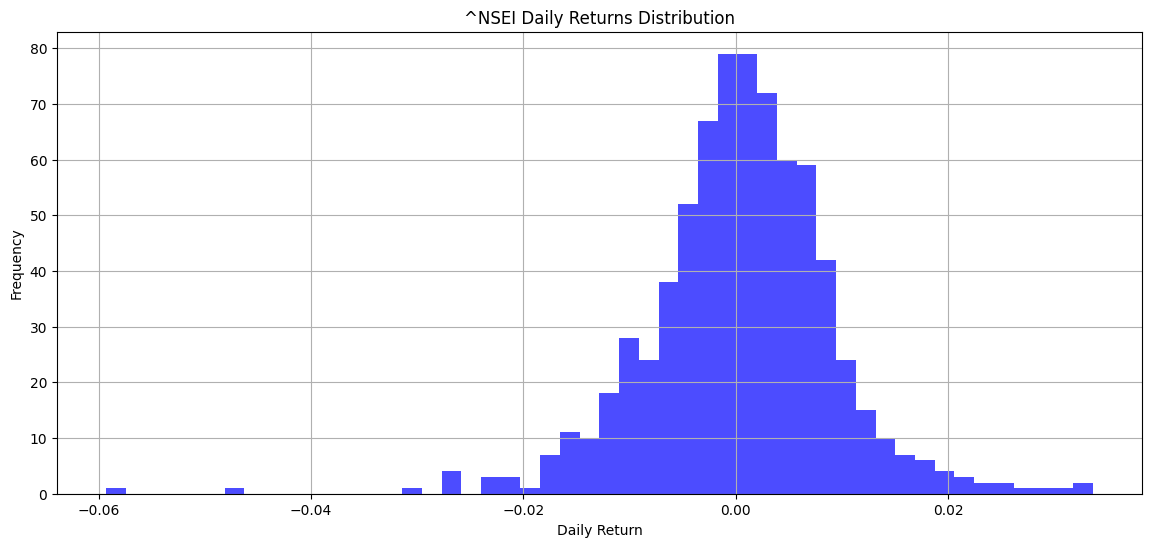

In [14]:
# 4. Distribution of Returns
data['Returns'] = data['Close'].pct_change()  # Daily returns
plt.figure(figsize=(14, 6))
plt.hist(data['Returns'].dropna(), bins=50, color='blue', alpha=0.7)
plt.title(f'{ticker_symbol} Daily Returns Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [16]:
print(data.index)

DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=739, freq=None)


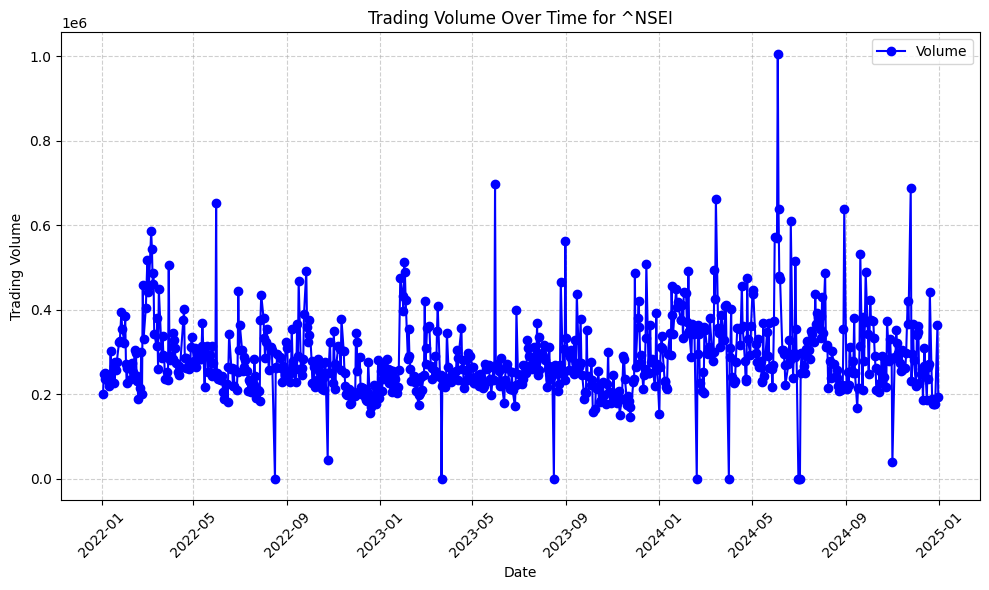

In [17]:
# Plot the Volume data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Volume'], label='Volume', color='blue', marker='o')

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title(f"Trading Volume Over Time for {ticker_symbol}")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(rotation=45)

# Show the graph
plt.tight_layout()
plt.show()

In [19]:
print("Column names:", data.columns.get_level_values(0))

Column names: Index(['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_50', 'EMA_50', 'RSI',
       'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'Returns'],
      dtype='object', name='Price')


In [20]:
def check_missing_values(df):
    """
    Function to check and print the count of missing values per column.
    Also provides a message if there are no missing values.
    """
    missing_values = df.isnull().sum()  # Get missing values per column
    total_missing = missing_values.sum()  # Total missing values across all columns

    # Print the missing values per column
    print("Missing values per column:")
    print(missing_values)

    # Provide a message based on the result
    if total_missing == 0:
        print("\nGreat! There are no missing values in the dataset.")
    else:
        print(f"\nThere are {total_missing} missing values in the dataset.")

# Example usage
check_missing_values(data)

Missing values per column:
Price        Ticker
Close        ^NSEI     0
High         ^NSEI     0
Low          ^NSEI     0
Open         ^NSEI     0
Volume       ^NSEI     0
SMA_50                 0
EMA_50                 0
RSI                    1
EMA_12                 0
EMA_26                 0
MACD                   0
Signal_Line            0
Returns                1
dtype: int64

There are 2 missing values in the dataset.


In [21]:
data=data.dropna()

In [22]:
# we compare next day closing price to the current day closing price to check whether to buy or sell
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)  # 1 for buy, sell for down

<ipython-input-22-34bc972e9f31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)  # 1 for buy, sell for down


In [23]:
data.head()

Price,Close,High,Low,Open,Volume,SMA_50,EMA_50,RSI,EMA_12,EMA_26,MACD,Signal_Line,Returns,Target
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,,,,
Date,,,,,,,,,,,,,,
2022-01-04,17805.250000,17827.599609,17593.550781,17681.400391,247400,17715.474609,17632.740426,100.000000,17653.322416,17638.999277,14.323139,2.864628,0.010187,1
2022-01-05,17925.250000,17944.699219,17748.849609,17820.099609,251500,17785.399740,17644.211390,100.000000,17695.157429,17660.203034,34.954395,9.282581,0.006740,0
2022-01-06,17745.900391,17797.949219,17655.550781,17768.500000,236500,17775.524902,17648.199194,62.549705,17702.964038,17666.550986,36.413052,14.708675,-0.010005,1
2022-01-07,17812.699219,17905.000000,17704.550781,17797.599609,239300,17782.959766,17654.650175,67.133981,17719.846374,17677.376781,42.469593,20.260859,0.003764,1
2022-01-10,18003.300781,18017.449219,17879.150391,17913.300781,232400,17819.683268,17668.322748,75.641801,17763.454744,17701.519300,61.935444,28.595776,0.010700,1


In [24]:
features = ['SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'Returns']
X = data[features]
y = data['Target']

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [26]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [27]:
# Logistic regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
# random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.43      0.65      0.52        69
           1       0.45      0.25      0.33        79

    accuracy                           0.44       148
   macro avg       0.44      0.45      0.42       148
weighted avg       0.44      0.44      0.42       148



In [31]:
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.53      0.99      0.69        79

    accuracy                           0.53       148
   macro avg       0.27      0.49      0.35       148
weighted avg       0.28      0.53      0.37       148



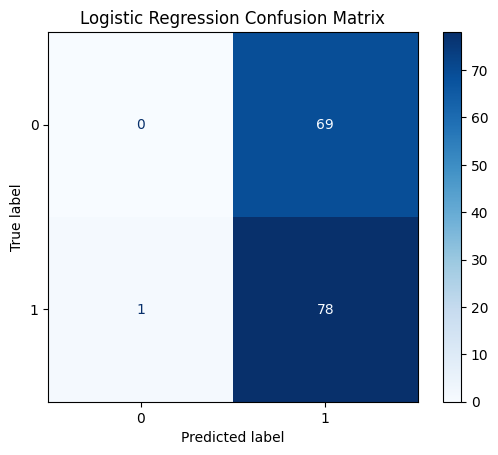

In [32]:
# Example for Logistic Regression
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, cmap='Blues', values_format='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

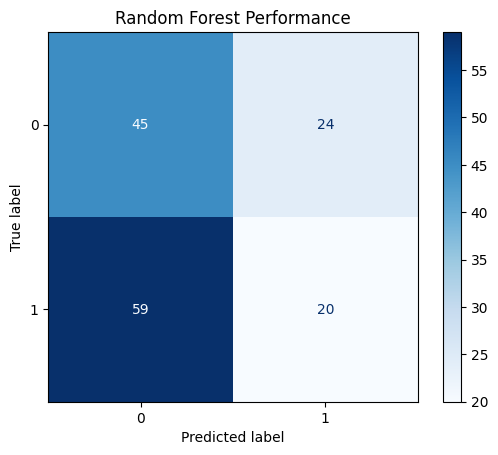

In [33]:
# Example for Random Forest Performance
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues', values_format='d')
plt.title("Random Forest Performance")
plt.show()